# 機械学習_効果測定 分類
選択したデータ : digits.csv

k分割交差検証で複数モデルの性能を評価し、最終的にはロジスティック回帰でモデルを作成しました。  
また、オリジナル画像を読み込み、作成したモデルで予測する関数を作成しました。  
モデルを決めるまでの流れ、オリジナル画像を予測した結果を以下に示します。

## ※ matplotlib日本語化のためのライブラリのインストール
### ▶ 以下を実行してください。

In [1]:
!pip install japanize-matplotlib
import japanize_matplotlib

import pandas as pd

     |████████████████████████████████| 4.1 MB 14.1 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=98b66db85888cca3944d3f60891d3a147f6ed1ac1222d86fef0d1b08142b9d57
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


CSVの内容は以下の通り  
※グレースケールの値については、0-1ではなく0-16の様子です。

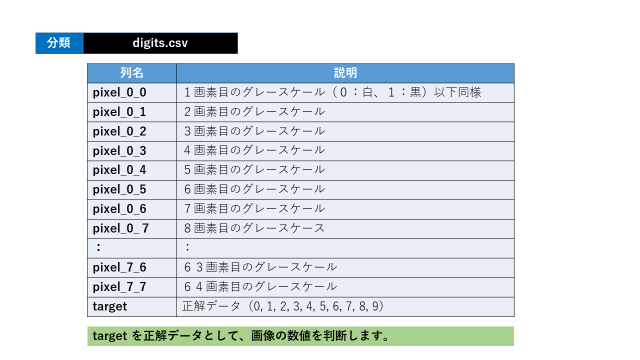

## ファイルの読み込み

In [2]:
# CSVファイルを読み込む
df = pd.read_csv('digits.csv', index_col='Unnamed: 0')

# 正しく読み込めていることを確認するため、内容を表示する
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [3]:
# データの規模感を確認しておく
print(df.shape[0],'行')
print(df.shape[1],'列')

1797 行
65 列


## 欠損値の確認

In [4]:
# 欠損値があると学習できないため、欠損値の有無を確認
df.isnull().any().any()

False

欠損値は無し

## データの偏りの確認

In [5]:
df['target'].value_counts()

3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: target, dtype: int64

ほぼ偏り無しだが、データ分割時にはこの割合を考慮することにする

## 特徴量、正解データの切り出し

In [6]:
# 特徴量を切り出す
X = df.drop('target',axis=1)
X.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,0,6,13,10,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,0,11,16,10,0,0
2,0,0,0,4,15,12,0,0,0,0,...,5,0,0,0,0,3,11,16,9,0
3,0,0,7,15,13,1,0,0,0,8,...,9,0,0,0,7,13,13,9,0,0
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,0,2,16,4,0,0


In [7]:
# 特徴量を切り出す
y = df['target']
y.head()

0    0
1    1
2    2
3    3
4    4
Name: target, dtype: int64

## k分割交差検証でモデルの性能を確認する

モデルを変えて検証するため、処理を関数化(learn)しておく

In [8]:
# k分割交差検証(Stratified)をインポート
from sklearn.model_selection import StratifiedKFold

# cross_validateインポート
from sklearn.model_selection import cross_validate

# モデル、特徴量、正解データを引数で受け取り、k分割交差検証を行う
# 交差検証の結果はDataFrameに変換して返す
# * 評価指標は'r2(決定係数)'とする
# * 訓練データでの結果も取得する
def learn(model, X, y):
  # KFoldのオブジェクトを作成する
  skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

  result = cross_validate(model, X, y, cv=skf, scoring='accuracy', return_train_score = True)

  return pd.DataFrame(result)

### ロジスティック回帰

In [9]:
# インポート
from sklearn.linear_model import LogisticRegression

solver、alphaを変えながら性能を検証する

In [10]:
# モデル作成
# solverのlbgfsは列数が多いため使えなかった
for sol in ['newton-cg', 'sag', 'saga']:
  print('■', sol)

  # 検証結果を集計しやすいように、データフレームに格納しておく
  result_df = pd.DataFrame(columns=['alpha', 'train_score', 'test_score'])

  for i in range(1, 10, 1):
    a = i / 100

    # デフォルトのmax_iterだと収束しない警告が出たため、max_iterの値を増やした
    model = LogisticRegression(C = a, random_state=0, multi_class = 'auto', solver = sol, max_iter=1000)

    result = learn(model, X, y)
    print('alpha={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

    result_df = result_df.append({'alpha':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

  print('==test_scoreが最大のケース==')
  print(result_df.iloc[result_df['test_score'].idxmax()])

■ newton-cg
alpha=0.01 train_score=0.9930443484968589 test_score=0.9710739709068401
alpha=0.02 train_score=0.997495942230133 test_score=0.9710755184153514
alpha=0.03 train_score=0.9980523672501919 test_score=0.9716295264623958
alpha=0.04 train_score=0.9984697102118364 test_score=0.9721850820179512
alpha=0.05 train_score=0.998608889056652 test_score=0.9716279789538843
alpha=0.06 train_score=0.9990262320182964 test_score=0.9705153203342618
alpha=0.07 train_score=0.9991653140767109 test_score=0.9705153203342618
alpha=0.08 train_score=0.9993044929215266 test_score=0.969958217270195
alpha=0.09 train_score=0.9997218358831711 test_score=0.9694011142061282
==test_scoreが最大のケース==
alpha          0.040000
train_score    0.998470
test_score     0.972185
Name: 3, dtype: float64
■ sag
alpha=0.01 train_score=0.991792126039123 test_score=0.9710708758898173
alpha=0.02 train_score=0.9970786960548896 test_score=0.970516867842773
alpha=0.03 train_score=0.9981915460950075 test_score=0.9716279789538843
alpha

### 決定木

In [11]:
# インポート
from sklearn import tree

深さを変えながら性能を検証する

In [22]:
# 検証結果を集計しやすいように、データフレームに格納しておく
result_df = pd.DataFrame(columns=['max_depth', 'train_score', 'test_score'])

# モデル作成
for a in range(1, 30, 1):
  # 深さaの決定木モデルを作成
  model = tree.DecisionTreeClassifier(max_depth = a, random_state = 0)

  result = learn(model, X, y)
  print('max_depth={} train_score={} test_score={}'.format(a, result['train_score'].mean(), result['test_score'].mean()))

  result_df = result_df.append({'max_depth':a, 'train_score':result['train_score'].mean(), 'test_score':result['test_score'].mean()}, ignore_index=True)

print('==test_scoreが最大のケース==')
print(result_df.iloc[result_df['test_score'].idxmax()])

max_depth=1 train_score=0.19824710148925234 test_score=0.19755184153512845
max_depth=2 train_score=0.31928236755022976 test_score=0.3183116682141752
max_depth=3 train_score=0.4820541558628847 test_score=0.4646703806870939
max_depth=4 train_score=0.5866731900701023 test_score=0.5581723924481585
max_depth=5 train_score=0.694631548688883 test_score=0.6550030950170226
max_depth=6 train_score=0.8162225622651114 test_score=0.7534880841844631
max_depth=7 train_score=0.8991389881756053 test_score=0.8169173630454967
max_depth=8 train_score=0.9316930941934934 test_score=0.8380516867842773
max_depth=9 train_score=0.9575684546018547 test_score=0.8464113277623028
max_depth=10 train_score=0.9773231397895671 test_score=0.8503033116682142
max_depth=11 train_score=0.9892874875508492 test_score=0.853644382544104
max_depth=12 train_score=0.9959653620827659 test_score=0.8564360878984836
max_depth=13 train_score=0.9988869563870798 test_score=0.8592169606932838
max_depth=14 train_score=0.9998608211551844 te

## 最終的なモデルの作成(ロジスティック回帰)

k分割交差検証の結果、ロジスティック回帰(solver=newton-cg)を用いることにする。  

In [13]:
from sklearn.model_selection import train_test_split

# stratify=yとし、正解データの種類の割合を考慮してデータを分割する
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [14]:
X_train.shape

(1437, 64)

In [15]:
# インポート
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(C = 0.04, random_state=0, multi_class = 'auto', solver = 'newton-cg')
model.fit(X_train, y_train)

# 正解率を確認する
# 検証結果の確認
print('訓練データでの決定係数:',model.score(X_train, y_train))
print('テストデータでの決定係数:',model.score(X_test, y_test))

訓練データでの決定係数: 0.9986082115518441
テストデータでの決定係数: 0.9638888888888889


完成したモデルを保存

In [16]:
# pickleライブラリのインポート
import pickle

# モデルを保存
with open('logistic_regression.pkl', 'wb') as f:
  pickle.dump(model, f)

## オリジナル画像を読み込んで予測する

画像を読み込んで予測する処理を関数化

In [17]:
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# ファイル名を指定すると、model.predictの結果を返す
def predict(filename):
  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

  # 画像が読み込めているかチェック
  if img is None:
    return '画像が読み込めませんでした'

  # 画像を表示 OpenCVはGBR順なのでRGB順に並べ替える
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

  # 読み込んだデータだと黒が0、白が255になっているので反転
  img2 = cv2.bitwise_not(img)

  # 画像サイズを特徴量のサイズ(8px x 8px)に合わせる
  img_resized = cv2.resize(img2 , (8, 8))

  # データを1次元に変形し、グレースケールを0-16の値にする
  predict_data = img_resized.reshape(1, 64) / 16

  # 予測結果を返す
  return model.predict(predict_data)

関数を使用し、オリジナル画像で予測する

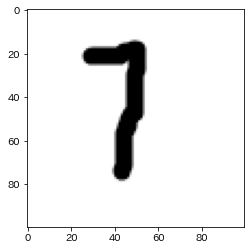

予測結果: [7]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [20]:
result = predict('image.png')
print('予測結果:', result)

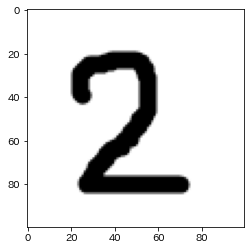

予測結果: [2]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


In [21]:
result = predict('image2.png')
print('予測結果:', result)